In [1]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install lifetimes

     |████████████████████████████████| 584 kB 238 kB/s eta 0:00:01
     |████████████████████████████████| 49 kB 6.0 MB/s  eta 0:00:01
     |████████████████████████████████| 116 kB 4.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install xlrd

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from sklearn.preprocessing import MinMaxScaler
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions,plot_history_alive
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [8]:
df = pd.read_excel('/Users/shivanireddy/Desktop/online_retail_II.xlsx')

In [9]:
sheet_name= ('Year 2010-2011')
df_ = df.copy()

In [10]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95000,13085.00000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75000,13085.00000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75000,13085.00000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10000,13085.00000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25000,13085.00000,United Kingdom


In [16]:
def check_df(dataframe):
    print("################ Shape ####################")
    print(dataframe.shape)
    print("############### Columns ###################")
    print(dataframe.columns)
    print("############### Types #####################")
    print(dataframe.dtypes)
    print("############### Head ######################")
    print(dataframe.head())
    print("############### Tail ######################")
    print(dataframe.tail())
    print("############### Describe ###################")
    print(dataframe.describe().T)

check_df(df)

################ Shape ####################
(417534, 8)
############### Columns ###################
Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')
############### Types #####################
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object
############### Head ######################
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   


In [20]:
# To find null values 

In [21]:
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [15]:
df.dropna(inplace=True)

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [22]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [23]:
df_uk = df[df['Country'] == 'United Kingdom']

In [24]:
df_uk = df_uk[~df_uk['Invoice'].str.contains('C', na=False)]

In [25]:
df_uk = df_uk[df_uk['Price'] > 0]

In [26]:
replace_with_thresholds(df_uk, 'Price')
replace_with_thresholds(df_uk, 'Quantity')

In [27]:
df_uk.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.00000,2009-12-01 07:45:00,6.95000,13085.00000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12.00000,2009-12-01 07:45:00,6.75000,13085.00000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12.00000,2009-12-01 07:45:00,6.75000,13085.00000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.00000,2009-12-01 07:45:00,2.10000,13085.00000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.00000,2009-12-01 07:45:00,1.25000,13085.00000,United Kingdom


In [28]:
df_uk['TotalPrice'] = df_uk['Quantity'] * df_uk['Price']

In [29]:
df_uk[df_uk['Invoice'] == 536365]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
502938,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.00000,2010-12-01 08:26:00,2.55000,17850.00000,United Kingdom,15.30000
502939,536365,71053,WHITE METAL LANTERN,6.00000,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom,20.34000
502940,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.00000,2010-12-01 08:26:00,2.75000,17850.00000,United Kingdom,22.00000
502941,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.00000,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom,20.34000
502942,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.00000,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom,20.34000
502943,536365,22752,SET 7 BABUSHKA NESTING BOXES,2.00000,2010-12-01 08:26:00,7.65000,17850.00000,United Kingdom,15.30000
502944,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6.00000,2010-12-01 08:26:00,4.25000,17850.00000,United Kingdom,25.50000


In [30]:
df_uk['InvoiceDate'].max()

Timestamp('2010-12-09 20:01:00')

In [31]:
df_uk['InvoiceDate'].min()

Timestamp('2009-12-01 07:45:00')

In [32]:
today_date = dt.datetime(2011, 12, 11)

In [33]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95000,13085.00000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75000,13085.00000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75000,13085.00000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10000,13085.00000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25000,13085.00000,United Kingdom


In [34]:
df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

In [35]:
df_uk = df_uk.groupby('Customer ID').agg({'TotalPrice':'sum',
                              'InvoiceDate': [lambda date: (date.max()-date.min()).days,
                                              lambda date: (today_date - date.min()).days],
                              'Invoice': lambda Invoice: Invoice.nunique()})

In [38]:
df_uk.head()

TotalPrice InvoiceDate             Invoice
                   sum  <lambda_0> <lambda_1> <lambda>
Customer ID                                           
12346.00000  372.86000         196        726       11
12608.00000  415.79000           0        405        1
12745.00000  723.85000          87        575        2
12746.00000  254.55000           0        541        1
12747.00000 5080.53000         363        733       16

In [39]:
df_uk.columns.droplevel(0)

Index(['sum', '<lambda_0>', '<lambda_1>', '<lambda>'], dtype='object')

In [40]:
df_uk.columns = ['monetary', 'recency', 'T', 'frequency']

In [41]:
df_uk.head()

,monetary,recency,T,frequency
Customer ID,,,,
12346.00000,372.86000,196,726,11
12608.00000,415.79000,0,405,1
12745.00000,723.85000,87,575,2
12746.00000,254.55000,0,541,1
12747.00000,5080.53000,363,733,16


In [47]:
df_uk['monetary'] = df_uk['monetary'] / df_uk['frequency']
df_uk = df_uk[df_uk['frequency'] > 1]
df_uk['recency'] = df_uk['recency'] / 7
df_uk['T'] = df_uk['T'] / 7


,coef,se(coef),lower 95% bound,upper 95% bound
r,2.41852,0.09732,2.22777,2.60927
alpha,0.00438,0.00020,0.00398,0.00478
a,6.96111,0.77595,5.44025,8.48197
b,30.67800,3.84058,23.15046,38.20554


In [75]:
bgf = BetaGeoFitter()
bgf.fit(df_uk['frequency'], df_uk['recency'], df_uk['T'])

<lifetimes.BetaGeoFitter: fitted with 2665 subjects, a: 6.96, alpha: 0.00, b: 30.68, r: 2.42>

In [76]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,2.41852,0.09732,2.22777,2.60927
alpha,0.00438,0.00020,0.00398,0.00478
a,6.96111,0.77595,5.44025,8.48197
b,30.67800,3.84058,23.15046,38.20554


In [52]:
bgf.conditional_expected_number_of_purchases_up_to_time(1, df_uk['frequency'], df_uk['recency'], df_uk['T']).sort_values(ascending=False).head(10)

Customer ID
15989.00000   1.44263
16204.00000   1.35462
16720.00000   1.35180
14119.00000   1.34172
17193.00000   1.33071
15169.00000   1.31711
17411.00000   1.31452
17251.00000   1.30653
17591.00000   1.28617
17776.00000   1.24644
dtype: float64

In [53]:
df_uk['expected_purch_6month'] = bgf.predict(4*6, df_uk['frequency'], df_uk['recency'], df_uk['T'])

In [54]:
df_uk.sort_values(by='expected_purch_6month', ascending= False).head()

,monetary,recency,T,frequency,expected_purch_6month
Customer ID,,,,,
15989.00000,46.56375,0.02148,0.04391,2,1.44973
16204.00000,67.31625,0.02082,0.04355,2,1.36116
16720.00000,79.61000,0.02053,0.04302,2,1.35812
14119.00000,22.92125,0.02035,0.04278,2,1.34791
17193.00000,76.34250,0.02088,0.04391,2,1.33726


In [55]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

In [56]:
ggf.fit(df_uk['frequency'], df_uk['monetary'])

<lifetimes.GammaGammaFitter: fitted with 2665 subjects, p: 1.00, q: 0.39, v: 1.15>

In [57]:
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,1.00450,0.05670,0.89336,1.11563
q,0.39110,0.00906,0.37334,0.40887
v,1.15175,0.08055,0.99387,1.30963


In [58]:
ggf.conditional_expected_average_profit(df_uk['frequency'], df_uk['monetary']).sort_values(ascending=False).head(10)

Customer ID
14091.00000   1628.87692
16749.00000    787.70247
13763.00000    629.03870
15786.00000    626.01107
14088.00000    625.78411
13334.00000    489.93438
12967.00000    475.42219
17686.00000    459.51814
15077.00000    436.33200
15050.00000    433.39404
dtype: float64

In [59]:
#########
df_uk['expected_average_profit'] = ggf.conditional_expected_average_profit(df_uk['frequency'], df_uk['monetary'])
#########

In [60]:
cltv = ggf.customer_lifetime_value(bgf, df_uk['frequency'], df_uk['recency'], df_uk['T'], df_uk['monetary'], time=6, freq='W')

In [61]:
cltv = cltv.reset_index()

In [62]:
cltv_final = df_uk.merge(cltv, on='Customer ID', how='left')

In [63]:

cltv_final.sort_values(by='clv', ascending=False).head()

,Customer ID,monetary,recency,T,frequency,expected_purch_6month,expected_average_profit,clv
30,12873.00000,206.66250,0.01690,0.04058,2,0.92719,297.36578,272.98588
206,13253.00000,240.08875,0.01624,0.04189,2,0.73594,345.32902,251.62521
586,14038.00000,188.68750,0.01642,0.04010,2,0.88592,271.57350,238.20992
1466,15865.00000,169.22375,0.01725,0.04189,2,0.88565,243.64502,213.64800
2480,17857.00000,140.74687,0.01636,0.03820,2,1.03335,202.78363,207.47254


In [64]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [65]:
cltv_final.head()

,Customer ID,monetary,recency,T,frequency,expected_purch_6month,expected_average_profit,clv
0,12346.00000,0.28014,0.01166,0.04320,11,0.00002,0.40728,0.00001
1,12745.00000,90.48125,0.00518,0.03421,2,0.06123,130.65762,7.92098
2,12747.00000,1.24036,0.02160,0.04361,16,0.00071,1.36403,0.00096
3,12748.00000,0.00678,0.02196,0.04379,144,0.00000,0.01484,0.00000
4,12749.00000,43.85125,0.00720,0.03106,4,0.02503,52.02289,1.28919


In [66]:
scaler.fit(cltv_final[['clv']])

MinMaxScaler()

In [67]:
cltv_final['scaled_cltv'] = scaler.transform(cltv_final[['clv']])


In [68]:
cltv_final.sort_values(by='scaled_cltv', ascending=False).head()


,Customer ID,monetary,recency,T,frequency,expected_purch_6month,expected_average_profit,clv,scaled_cltv
30,12873.00000,206.66250,0.01690,0.04058,2,0.92719,297.36578,272.98588,1.00000
206,13253.00000,240.08875,0.01624,0.04189,2,0.73594,345.32902,251.62521,0.92175
586,14038.00000,188.68750,0.01642,0.04010,2,0.88592,271.57350,238.20992,0.87261
1466,15865.00000,169.22375,0.01725,0.04189,2,0.88565,243.64502,213.64800,0.78263
2480,17857.00000,140.74687,0.01636,0.03820,2,1.03335,202.78363,207.47254,0.76001


In [69]:
cltv_final.sort_values(by='scaled_cltv', ascending=False).tail()


,Customer ID,monetary,recency,T,frequency,expected_purch_6month,expected_average_profit,clv,scaled_cltv
866,14606.00000,0.01756,0.02196,0.04385,102,0.00000,0.02902,0.00000,0.00000
132,13089.00000,0.04472,0.02190,0.04391,109,0.00000,0.05559,0.00000,0.00000
1208,15311.00000,0.03152,0.02219,0.04397,121,0.00000,0.04125,0.00000,0.00000
3,12748.00000,0.00678,0.02196,0.04379,144,0.00000,0.01484,0.00000,0.00000
2475,17850.00000,0.01373,0.02154,0.04373,155,0.00000,0.02125,0.00000,0.00000


<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

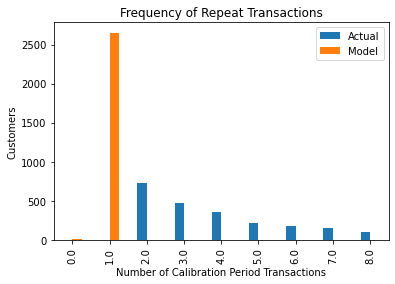

In [70]:
plot_period_transactions(bgf)

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

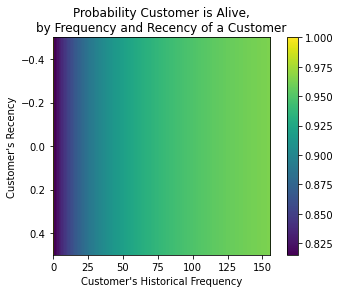

In [71]:
plot_probability_alive_matrix(bgf)